In [3]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 생성되는 이미지를 관찰하기 위함, 3차원 플롯을 그리는 용도
from matplotlib import cm # 데이터 포인트에 색상을 입히는 것에 사용
import numpy as np

In [4]:
EPOCH = 10
BATCH_SIZE =32
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


# 데이터셋 불러오기

In [6]:
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader (
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

100%|██████████| 26421880/26421880 [00:14<00:00, 1803507.71it/s]


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 125567.01it/s]


Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2280643.65it/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20781787.29it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



# 오토인코더 모듈 정의

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3)
        )

        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid() # 픽셀 당 0 과 1 사이로 값을 출력하는 sigmoid() 함수
        )
    def forward(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return encoded, decoded

In [8]:
autoencoder= Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [9]:
view_data = trainset.data[:5].view(-1,28*28)
view_data=view_data.type(torch.FloatTensor)/255

# 학습

In [10]:
def train(autoencder, train_loader):
    autoencoder.train() # train 모드로 바꾼다.
    for step, (x,label) in enumerate(train_loader):
        x=x.view(-1,28*28).to(DEVICE)
        y=x.view(-1,28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded=autoencoder(x)

        loss = criterion(decoded, y)
        optimizer.zero_grad() # 기울기에 대한 정보를 초기화
        loss.backward() # 기울기를 구한다
        optimizer.step() # 최적화를 진행

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1]


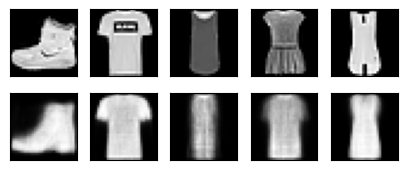

[Epoch 2]


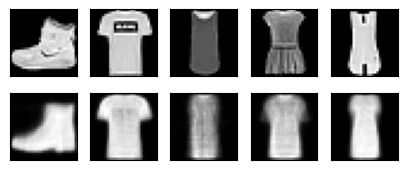

[Epoch 3]


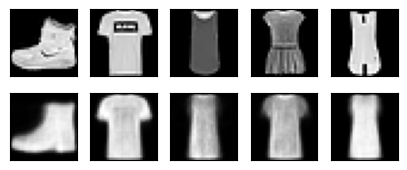

[Epoch 4]


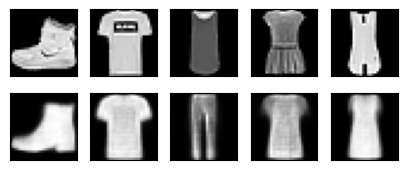

[Epoch 5]


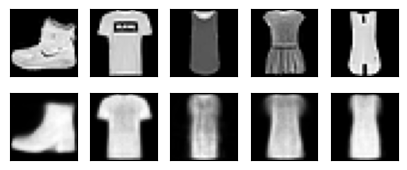

[Epoch 6]


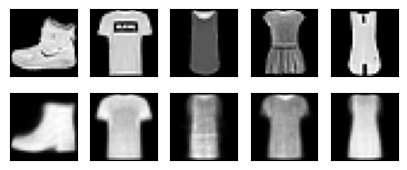

[Epoch 7]


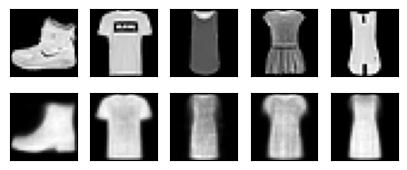

[Epoch 8]


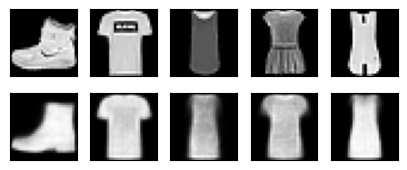

[Epoch 9]


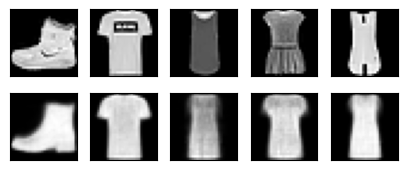

[Epoch 10]


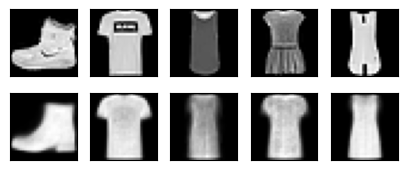

In [11]:
for epoch in range(1, EPOCH+1) :
    train(autoencoder, train_loader)

    test_x=view_data.to(DEVICE)
    _,decoded_data= autoencoder(test_x)

    # 원본과 디코딩 결과 비교
    f,a=plt.subplots(2,5,figsize=(5,2))
    print("[Epoch {}]".format(epoch))
    for i in range(5) :
        img=np.reshape(view_data.data.numpy()[i],(28,28)) # 파이토치 텐서를 넘파이로 변환
        a[0][i].imshow(img,cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    for i in range(5) :
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28,28))
        a[1][i].imshow(img,cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()

# 잠재변수 들여다보기

In [33]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data,_= autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

In [31]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


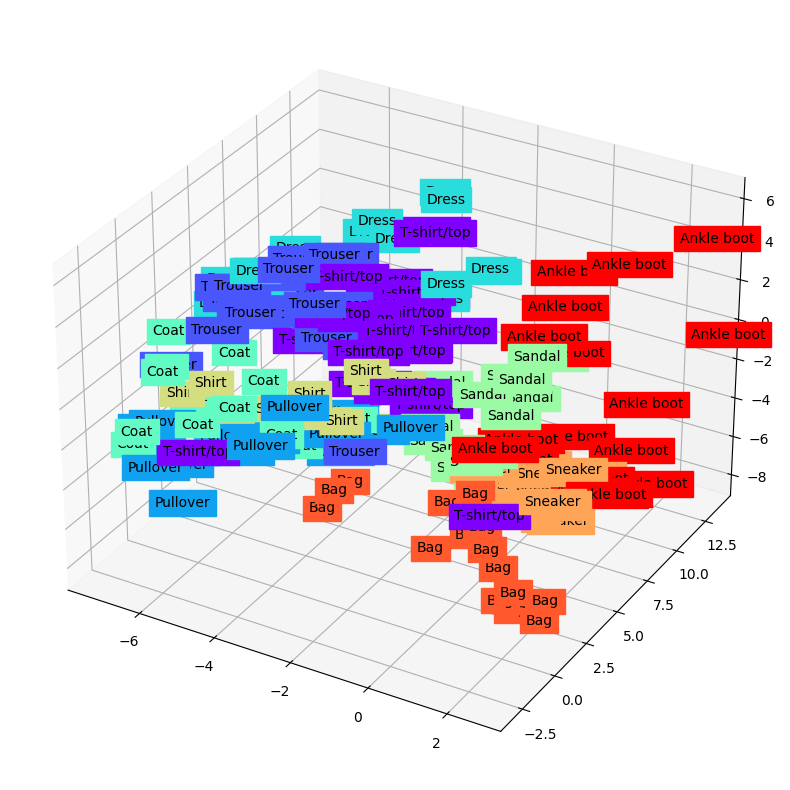

In [43]:
fig = plt.figure(figsize=(12,10))
# ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

X=encoded_data.data[:,0].numpy()
Y=encoded_data.data[:,1].numpy()
Z=encoded_data.data[:,2].numpy() # 잠재변수의 각 차원을 numpy 행렬로 변환한다
labels = trainset.targets[:200].numpy() # 라벨도 numpy 로 바꾼다

for x,y,z,s in zip(X,Y,Z, labels): # zip() 은 같은 길이의 행렬들을 모아 순서대로 묶어준다
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z,name,backgroundcolor=color)

ax.set_xlim(X.min(),X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(),Z.max())
plt.show()

In [45]:
def add_noise(img) :
    noise = torch.randn(img.size())*2
    noisy_img = img+noise
    return noisy_img

In [46]:
def train (autoencoder, train_loader):
    autoencoder.train()
    avg_loss=0
    for step, (x,label) in enumerate(train_loader):
        noisy_x = add_noise(x) # 입력에 노이즈 더하기
        noisy_x = noisy_x.view(-1, 28*28).to(DEVICE)
        y=x.view(-1,28*28).to(DEVICE)

        label = label.to(DEVICE)
        encoded,decoded = autoencoder(noisy_x)

        loss = criterion(decoded,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
    print("len(train_loager={})".format(len(train_loader)))
    return avg_loss / len(train_loader)

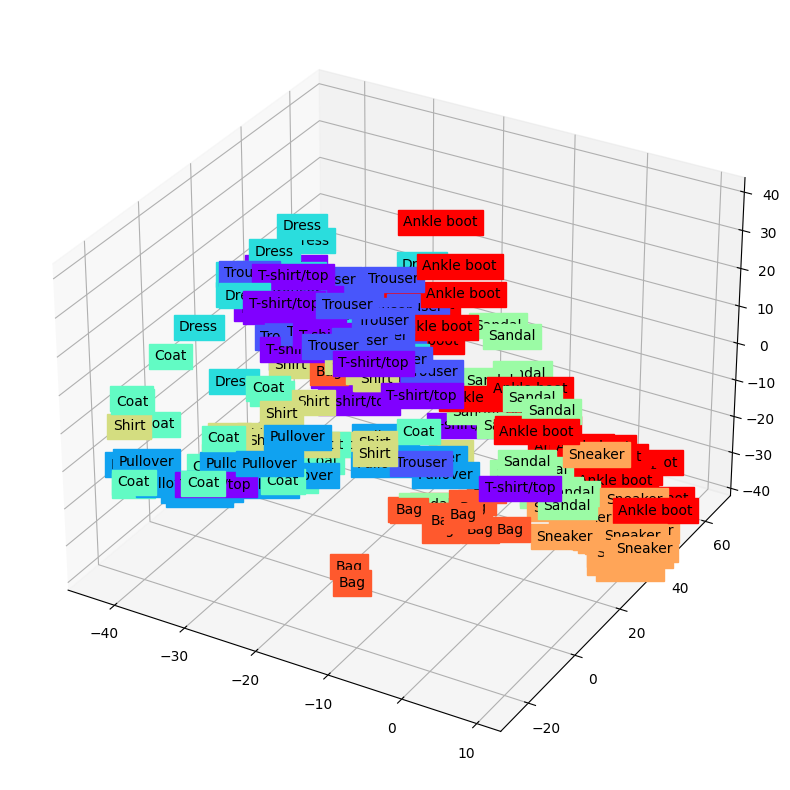

In [50]:
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE)
encoded_data,_= autoencoder(test_x)
encoded_data = encoded_data.to("cpu")

fig = plt.figure(figsize=(12,10))
# ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

X=encoded_data.data[:,0].numpy()
Y=encoded_data.data[:,1].numpy()
Z=encoded_data.data[:,2].numpy() # 잠재변수의 각 차원을 numpy 행렬로 변환한다
labels = trainset.targets[:200].numpy() # 라벨도 numpy 로 바꾼다

for x,y,z,s in zip(X,Y,Z, labels): # zip() 은 같은 길이의 행렬들을 모아 순서대로 묶어준다
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z,name,backgroundcolor=color)

ax.set_xlim(X.min(),X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(),Z.max())
plt.show()

In [47]:
for epoch in range(1, EPOCH+1) :
    loss = train(autoencoder, train_loader)
    print("[EPOCH {}] loss:{}".format(epoch,loss))

len(train_loager=1875)
[EPOCH 1] loss:0.04782946845889092
len(train_loager=1875)
[EPOCH 2] loss:0.044103773494561516
len(train_loager=1875)
[EPOCH 3] loss:0.04314763942360878
len(train_loager=1875)
[EPOCH 4] loss:0.04275054070750872
len(train_loager=1875)
[EPOCH 5] loss:0.04232150395313899
len(train_loager=1875)
[EPOCH 6] loss:0.042137194273869194
len(train_loager=1875)
[EPOCH 7] loss:0.042055700091520945
len(train_loager=1875)
[EPOCH 8] loss:0.04192481372952461
len(train_loager=1875)
[EPOCH 9] loss:0.04181536499559879
len(train_loager=1875)
[EPOCH 10] loss:0.04166256526807944


In [48]:
# 잡음제거 시각화
# 모델이 학습시 본적이 없는 데이터로 검증하기 위해 테스트 데이터셋을 가져온다
testset = datasets.FashionMNIST(
    root      = './.data/',
    train     = False, #test데이터셋
    download  = True,
    transform = transforms.ToTensor()
)

# 테스트셋에서 이미지 한장을 가져온다.
sample_data = testset.data[0].view(-1, 28*28) #1차원 행렬로 변환합니다
sample_data = sample_data.type(torch.FloatTensor)/255.

# 이미지를 add_noise로 오염시킨 후, 모델에 통과시킨다.
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x) #인코딩된 것은 무시하고 복원된 이미지만 보기 위해 첫 변수는 "_"로 이름 짓는다.

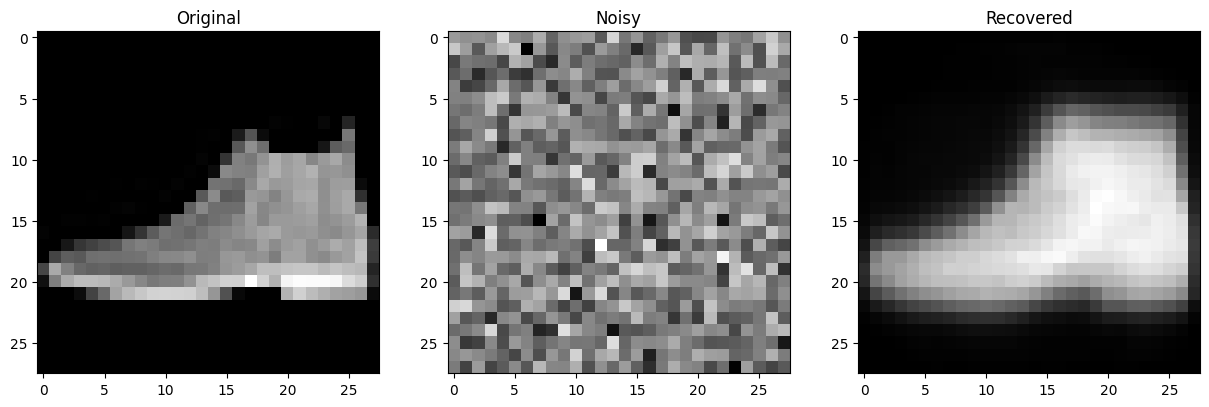

In [49]:
f, a = plt.subplots(1, 3, figsize=(15, 15)) #1행 3열의 표

# 시각화를 위해 넘파이 행렬로 바꾼다.
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본 사진
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

# 오염된 원본 사진
a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

# 복원된 사진
a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()